In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.preprocessing import FunctionTransformer
import matplotlib.dates as mdates

#### 💾CARREGA E AGRUPA POR DIA

In [3]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# filtra CP 4610, converte e ordena
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# agrega média diária de ActiveEnergy(kWh)
daily = (
    df_cp
    .set_index("DateTime")
    .resample("D")["ActiveEnergy(kWh)"]
    .mean()
    .to_frame("ActiveEnergy")
    .reset_index()
)

#### CRIA LAG DE 7 DIAS (exógena)

In [46]:
daily["lag_7"] = daily["ActiveEnergy"].shift(7)

# descarta primeiras 7 linhas com NaN
daily = daily.dropna().reset_index(drop=True)

# marca sempre o mesmo id ("4610") para montar o TimeSeriesDataFrame
daily["ZipCode"] = "4610"

# extrai static feature
static_feats = df_cp[["ZipCode","PopulationDensity"]].drop_duplicates()

#### MONTA O TimeSeriesDataFrame

In [47]:
ts_df = TimeSeriesDataFrame.from_data_frame(
    daily,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

#### 🛠 SPLIT TREINO/TESTE: últimos 7 dias em teste

In [48]:
prediction_length=7
train_daily, test_daily = ts_df.train_test_split(prediction_length=prediction_length)

# Modelos Tradicionais (Baseline)
# 📊ARIMA
#### 💾 (Opcional) Carregar um modelo existente

In [6]:
predictor_arima = TimeSeriesPredictor.load("./predicts/ARIMA_daily/modelo/")

#### 🛠️ Treinar

In [62]:
predictor_arima = TimeSeriesPredictor(
    target="ActiveEnergy",
    freq="D",
    prediction_length=prediction_length,
    path="predicts/ARIMA_daily/modelo",
    verbosity=2
).fit(
    train_data=train_daily,
    tuning_data=test_daily,
    hyperparameters={
        "ARIMAModel": {
            "order": (1, 1, 1),            # (p, d, q)
            "seasonal_order": (1, 0, 1, 7),# (P, D, Q, m)
            "target_scaler": "standard"   # normaliza o target
        }
    },
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True      # força só ARIMA, sem ensembles
)

# Salva o modelo
predictor_arima.save()

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA_daily\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.69 GB / 15.93 GB (23.2%)
Disk Space Avail:   690.66 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'ARIMAModel': {'order': (1, 1, 1),
                                    'seasonal_order': (1, 0, 1, 7),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 7,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows':

#### 🔮 Previsão com os dados de treino

In [7]:
# faz a previsão dos próximos 7 dias
future_preds = predictor_arima.predict(train_daily)

# extrai o quantil 0.5 e “desempacota” o índice de item_id
y_pred = future_preds["0.5"].droplevel(0)
y_true_full = test_daily["ActiveEnergy"].droplevel(0)

# extrai só os 7 valores reais que estão em test_daily
y_true = y_true_full.iloc[-7:]

y_true.shape: (7,)
y_pred.shape: (7,)


#### 📊  Avaliação do modelo

In [ ]:
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2   = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor | Interpretação |
|---------------------------------------------|-------|---------------|
| **MAE** (Erro Absoluto Médio)               | 290.85553 | Em média, as previsões diferem dos valores reais em cerca de 290,86 kWh. |
| **MSE** (Erro Quadrático Médio)             | 122719.42992   | Erro médio ao quadrado, penaliza fortemente grandes desvios. |
| **RMSE** (Raiz do Erro Quadrático Médio)    | 350.31333 | Desvio típico das previsões em relação ao real é de aproximadamente 350,31 kWh. |
| **MAPE** (Erro Percentual Absoluto Médio)   | 3.22% | Em média, as previsões estão 3,22 % distantes dos valores reais. |
| **R²**   | 0.96791 | O modelo explica 96,79 % da variância observada nos dados — indicativo de um bom ajuste. |

#### 📈 Visualização dos resultados

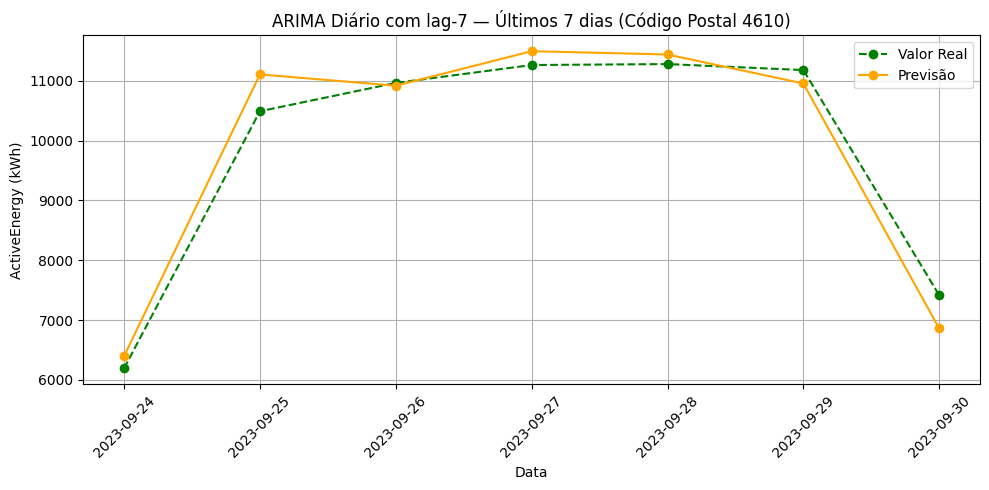

In [10]:
# valor real vs previsão
plt.figure(figsize=(10,5))
plt.plot(y_true.index, y_true.values, marker='o', linestyle='--',  label='Valor Real',  color='green')
plt.plot(y_pred.index, y_pred.values, marker='o', label='Previsão',  color='orange')
plt.xlabel("Data")
plt.ylabel("Consumo Energético (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("ARIMA Diário com lag-7 — Últimos 7 dias (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("figuras/arima_daily_forecast.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
O ARIMA diário com lag-7 atinge alta fidelidade (R²≈0,97) e baixos erros relativos (MAPE≈3%), mostrando-se robusto para a agregação diária do consumo. Os maiores desvios ocorrem em transições bruscas (início/fim de mês), mas continuam dentro de margens aceitáveis para aplicações de planeamento e gestão de energia.

# Modelos ML & DL
# 📊RF

In [97]:
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Agregação diária: média de consumo e temperatura
daily = (
    df_cp
    .groupby("Date")
    .agg({
        "ActiveEnergy(kWh)": "mean",
        "Temperature": "mean"
    })
    .rename(columns={
        "ActiveEnergy(kWh)": "ActiveEnergyMean",
        "Temperature": "TempMeanDaily"
    })
    .reset_index()
)

# Junta as restantes features com base na 1ª ocorrência de cada dia
first_obs = df_cp.sort_values("DateTime").drop_duplicates("Date")
features_to_keep = ["Date","IsWeekend", "Season", "IsHoliday", "DayOfTheWeek", "Month", "TimeOfDay"]
daily = daily.merge(first_obs[features_to_keep], on="Date", how="left")

# Aplica o mapeamento no DataFrame `daily`
# Mapeamento de TimeOfDay (Manhã, Tarde, Noite)
map_season = {
    "Outono": 0.0,
    "Primavera": 1.0,
    "Verão": 2.0,
    "Inverno": 3.0
}
daily["Season"] = daily["Season"].map(map_season)

# Mapeamento de DayOfTheWeek (Segunda a Domingo)
map_day_of_week = {
    "Segunda": 0.0,
    "Terça": 1.0,
    "Quarta": 2.0,
    "Quinta": 3.0,
    "Sexta": 4.0,
    "Sábado": 5.0,
    "Domingo": 6.0
}
daily["DayOfTheWeek"] = daily["DayOfTheWeek"].map(map_day_of_week)

map_time_of_day = {
    "Manhã": 0.0,
    "Tarde": 1.0,
    "Noite": 2.0
}
daily["TimeOfDay"] = daily["TimeOfDay"].map(map_time_of_day)

# Cria lag-7 e remove nulos
daily["lag_7"] = daily["ActiveEnergyMean"].shift(7)
daily = daily.dropna(subset=["lag_7"]).copy()

# Converte Date para datetime (necessário para o split)
daily["Date"] = pd.to_datetime(daily["Date"])

# Split treino/teste
prediction_length = 7
last_date = daily["Date"].max().date()
mask_train = daily["Date"].dt.date <= (last_date - pd.Timedelta(days=prediction_length))

# Define features e targets
features = ["lag_7", "TempMeanDaily", "IsWeekend", "Season", "IsHoliday", "DayOfTheWeek", "Month", "TimeOfDay"]
X_train = daily.loc[mask_train, features]
y_train = daily.loc[mask_train, "ActiveEnergyMean"]
X_test  = daily.loc[~mask_train, features]
y_test  = daily.loc[~mask_train, "ActiveEnergyMean"]

#### 💾 (Opcional) Carregar um modelo existente

In [102]:
pipeline = load("./predicts/RF_daily/modelo/RF_pipeline.joblib")

#### 🛠️ Treinar

In [98]:
pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("lag7", StandardScaler(), ["lag_7"]),
        ("temp", StandardScaler(), ["TempMeanDaily"]),
        ("season", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Season"]),
        ("holiday", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["IsHoliday"]),
        ("weekend", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["IsWeekend"]),
        ("dayoftheweek", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["DayOfTheWeek"]),
        ("timeofday", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["TimeOfDay"]),
        ("month", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Month"])
    ], remainder="drop")),  # Mantém só o que for transformado explicitamente
    ("rf", RandomForestRegressor(
        n_estimators=100, random_state=123, n_jobs=-1))
])

pipeline.fit(X_train, y_train)

dump(pipeline, "predicts/RF_daily/modelo/RF_pipeline.joblib") # Guarda o modelo treinado.

['predicts/RF_daily/modelo/RF_pipeline.joblib']

#### 🔮 Previsão com os dados de treino

In [103]:
# Faz a previsão dos próximos 7 dias
y_pred = pipeline.predict(X_test)

#### 📊  Avaliação do modelo

In [104]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test) * 100).mean()
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  250.41723
MSE:  107395.48020
RMSE: 327.71250
MAPE: 2.58348%
R²:   0.97191


### 📊 **Métricas de Avaliação**

| Métrica                                   | Valor        | Interpretação                                                                            |
| ----------------------------------------- |--------------|------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)             | 250.41723    | Em média, a previsão do modelo erra cerca de 250 kWh em relação ao valor real.           |
| **MSE** (Erro Quadrático Médio)           | 107395.48020 | O erro médio ao quadrado é elevado, o que penaliza mais os erros grandes.                |
| **RMSE** (Raiz do Erro Quadrático Médio)  | 327.71250    | O erro médio da previsão é de aproximadamente 327 kWh, numa escala comparável ao target. |
| **MAPE** (Erro Percentual Absoluto Médio) | 2.58%        | Em média, o modelo comete um erro de 2.58% em relação ao valor real — um bom desempenho. |
| **R²** (Coeficiente de Determinação)      | 0.97191      | O modelo explica cerca de 97.19% da variabilidade do consumo energético diário.          |

#### 📈 Visualização dos resultados

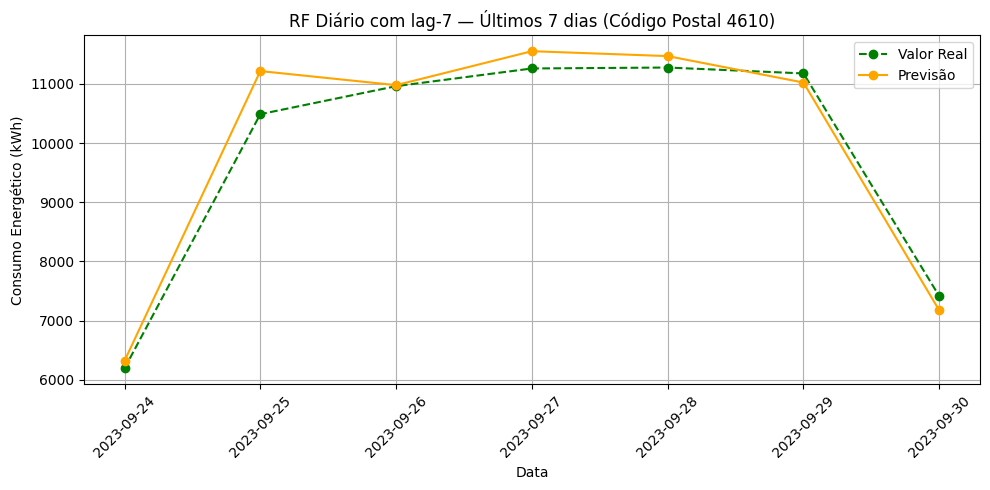

In [105]:
dates_test = daily.loc[~mask_train, "Date"]

plt.figure(figsize=(10, 5))
plt.plot(dates_test, y_test.values, marker='o', linestyle='--', label='Valor Real', color='green')
plt.plot(dates_test, y_pred, marker='o', label='Previsão', color='orange')
plt.xlabel("Data")
plt.ylabel("Consumo Energético (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("RF Diário com lag-7 — Últimos 7 dias (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("figuras/RF_daily_forecast.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
Com base nos resultados obtidos, o **Random Forest diário com lag-7** apresentou um desempenho **muito forte**, com um **R² de 0.97191**, indicando que é capaz de explicar **97.19% da variabilidade do consumo energético diário** no código postal 4610. O **MAPE de apenas 2.58%** confirma um nível de precisão bastante elevado, e os erros médios (MAE de \~250 kWh e RMSE de \~327 kWh) encontram-se num patamar competitivo e adequado à escala dos dados. No entanto, ao comparar com o modelo **ARIMA**, que obteve um **R² de 0.96791** e um **MAPE de 3.22%**, nota-se que o Random Forest supera ligeiramente o ARIMA em termos de **precisão e capacidade explicativa**. Além disso, o gráfico confirma uma sobreposição bastante próxima entre as previsões do Random Forest e os valores reais. Assim, conclui-se que, neste cenário, o modelo Random Forest não só iguala como **ultrapassa o ARIMA em desempenho**, sendo uma excelente escolha para a previsão diária do consumo energético.